# Prophet

Prophet is a Python time series forecast library developed by Facebook. Prophet can decompoe the time series and detect yearly, weekly, and daily seasonality.

## This notebook demonstrates the use of Prophet for time-series prediction of Bitcoin prices.

Topics covered:

* Train a time series forecasting model using Prophet.
* Make predictions
* Decompose time series
* Identify changing points in the trend
* Perform cross-validation
* Evaluate the prophet model

# Step 1: Install and Import `prophet` and `yfinance`

In the first step, we will install and import libraries. Two Python packages need to be installed, `yfinance` and `prophet`.


In [ ]:
# Install libraries
!pip install yfinance prophet

In [2]:
# Data processing
import numpy as np
import pandas as pd

# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

# Visualization
import plotly.graph_objs as go

# Step 2: Get Bitcoin Price Data

`yfinance` downloads data from Yahoo finance using API

In [10]:
# Download Bitcoin data
data = yf.download(tickers='BTC-USD', start='2021-01-01', end='2023-05-31', interval = '1d')

[*********************100%%**********************]  1 of 1 completed



Yahoo finance downloads data with the `date` as an index. Prophet requires the date-time variable as column for the model input and named as **'ds'** The target varaible named as **'y'**. Also, convert the date from string type to a DateTime format.

In [11]:
# Reset index and have date as a column
data.reset_index(inplace=True)

# Change date to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Take a look at the data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


From the trend chart, we can see that the Bitcoin price started to decrease in January 2018 and increased since April 2019.

In [12]:
# Plot the candlestick chart
fig = go.Figure()
fig.add_trace(go.Candlestick(x=data.Date,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'],
                name = 'Bitcoin Data'))

We will forecast the Bitcoin close price. Therefore, we will drop rest of the columns and rename `close` to `y`

In [13]:
# Keep only date and close price
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

# Rename date to ds and close price to y
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# View the data
df.head()

,ds,y
0,2021-01-01,29374.152344
1,2021-01-02,32127.267578
2,2021-01-03,32782.023438
3,2021-01-04,31971.914062
4,2021-01-05,33992.429688


Make sure you don't have any missing values in the dataset.

In [14]:
# Check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      880 non-null    datetime64[ns]
 1   y       880 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.9 KB


# Step 3: Train Test Split

Unlike most other multivariate datasets used for machine learning. We cannot  randomly split data for time series because it causes data leakage from the future dates to the past dates. Therefore, we will use date from `2021-01-01` to `2023-04-30` as training data and 30 days as test data.

In [16]:
# Train test split
df_train = df[df['ds']<='2023-04-30']
df_test = df[df['ds']>'2023-04-30']

# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())

The training dataset has 850 records, ranging from 2021-01-01 00:00:00 to 2023-04-30 00:00:00
The testing dataset has 30 records, ranging from 2023-05-01 00:00:00 to 2023-05-30 00:00:00


# Step 4: Train Time Series Model Using Prophet

Arguments:

`interval_width` specifies the prediction interval. The default value is 80% If you change it to 95%, it makes the upper bound and the lower bound of the prediction broader.

`n_changepoints` is the number of change points in the time series trend. The default value is 25. You have to observe the series and decide on the value. We will set it to 10, since we don't observe major changepoints as much as 25.

In [20]:
# Create the prophet model with confidence internal of 95%
m = Prophet(interval_width=0.90, n_changepoints=10)

# Fit the model using the training dataset
m.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/i_or3o37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/9n_hz5w7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96284', 'data', 'file=/tmp/tmp0jogs9cr/i_or3o37.json', 'init=/tmp/tmp0jogs9cr/9n_hz5w7.json', 'output', 'file=/tmp/tmp0jogs9cr/prophet_modelcyalexk5/prophet_model-20231029201448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


The yearly seasonality and daily seasonality are automatically disabled. This is because Prophet detects that the dataset we are using does not have full multiple years of data and does not have units smaller than a day.

# Step 5: Use Prophet Model To Make Prediction

We will use the trained Prophet model to make the predictions for the next 31 days.

The prediction output contains lots of information. We kept the predicted value `yhat` and its prediction interval upper and lower bound value.

In [21]:
# Create a future dataframe for prediction
future = m.make_future_dataframe(periods=31)

# Forecast the future dataframe values
forecast = m.predict(future)

# Check the forecasted values and upper/lower bound
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
876,2023-05-27,19356.823226,14127.820873,24720.180654
877,2023-05-28,19263.698208,14127.163591,24041.211219
878,2023-05-29,19159.205803,13764.766423,24358.547877
879,2023-05-30,19058.416395,13932.565286,24006.175125
880,2023-05-31,19098.742746,14022.075346,24143.584825


The x-axis is the date in the forecast visualization, and the y axis is the Bitcoin close price. The black dots are the actual prices in the training dataset, and the red dots are the actual forecast prices. The blue line is the time series model prediction. The shaded area is the 90% prediction interval.

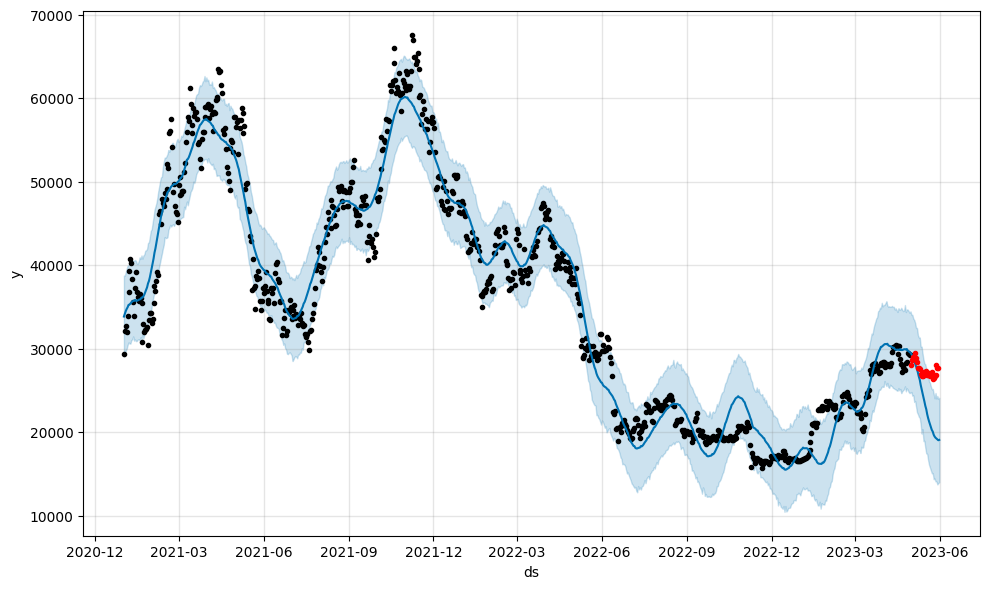

In [22]:
# Visualize the forecast
fig = m.plot(forecast)
ax = fig.gca()
ax.plot( df_test["ds"], df_test["y"], 'r.')

# Step 6: Time Series Decomposition

Let's decompose the time series forecast.

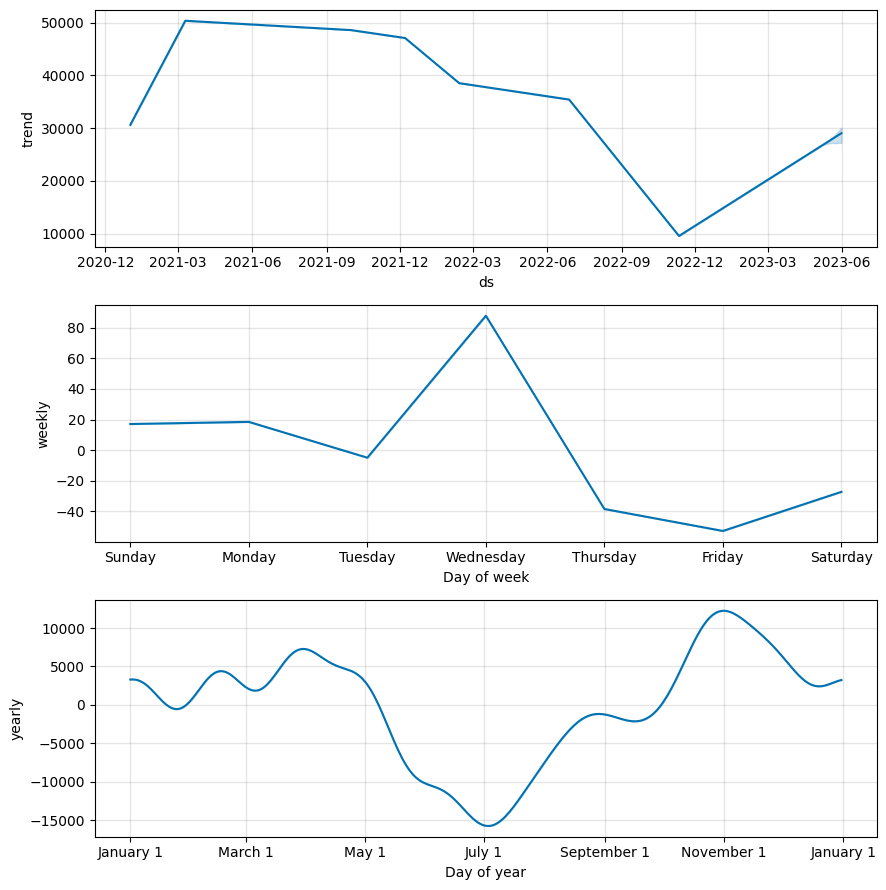

In [23]:
# Visualize the components
m.plot_components(forecast);


From the trend chart, we can see a decreasing trend from early 2021, an increasing trend from November 2022.

The weekly seasonality chart shows that the Bitcoin prices peak on wednesdays and drop to the lowest by Saturday's.

# Step 7: Identify Change Points

Let's identify the change points in the time series trend.

Prophet automatically identifies the change points in time series data following the steps below:

1. Specify the percentage of data used for identifying change points. The default is 80%.

2. Apply a sparse prior on the magnitudes of the change rate, which is similar to L1 regularization.

We can list the dates corresponding to the changepoints using `.changepoints`.


In [26]:
# Default change points
df.loc[df["ds"].isin(m.changepoints)]

,ds,y
68,2021-03-10,56008.550781
136,2021-05-17,43537.511719
204,2021-07-24,34292.445312
272,2021-09-30,43790.894531
340,2021-12-07,50700.085938
407,2022-02-12,42244.468750
475,2022-04-21,40527.363281
543,2022-06-28,20280.634766
611,2022-09-04,19986.712891
679,2022-11-11,17034.292969


In the visualization, the red dotted lines represent the changepoints. It does not include all the 10 changepoints in the chart. Only the ones with more changes are included.

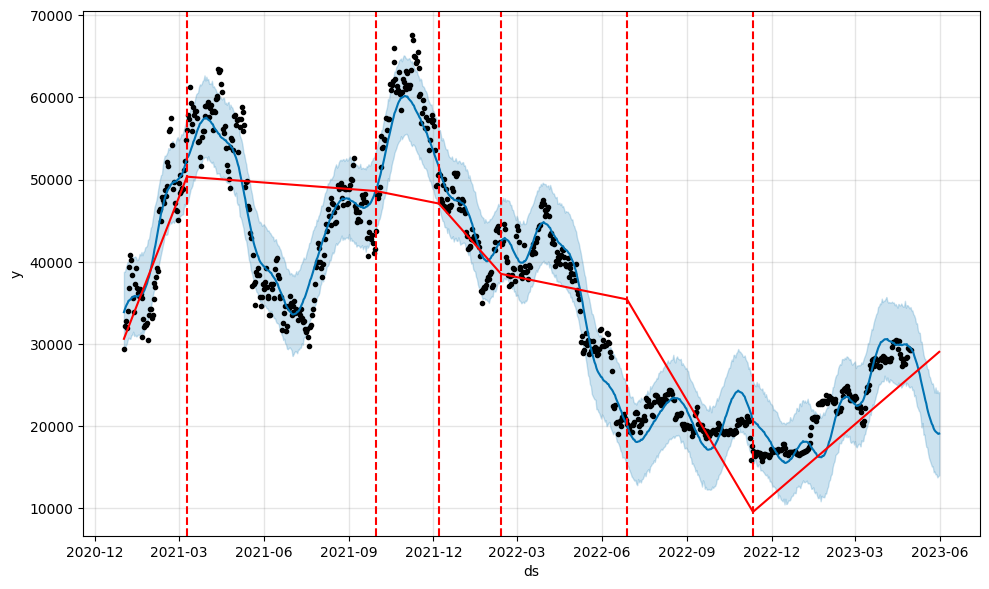

In [27]:
# Change points to plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Step 8: Cross Validation

Prophet has a `cross_validation` function to automate the comparison between the actual and the predicted values.

* `m' is the trained model.
* `initial='500 days" means the initial model will be trained on the first 500 days of data.
* `period='60 days" means 60 days will be added to the training dataset for each additional model.
* `horizon = '30 days'` means that the model forecasts the next 30 days. When only `horizon` is given, Prophet defaults `initial` to be triple the `horizon`, and `period` to be half of the `horizon`.
* `parallel="processes"` enables parallel processing for cross-validation. When the parallel cross-validation can be done on a single machine, "processes" provide the highest performance. For larger problems, "dask" can be used to do cross-validation on multiple machines.




In [28]:
# Cross validation
df_cv = cross_validation(m, initial='500 days', period='60 days', horizon = '30 days', parallel="processes")
df_cv.head()

INFO:prophet:Making 6 forecasts with cutoffs between 2022-06-04 00:00:00 and 2023-03-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c6617553d90>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/zg43yk2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/d3veop5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/d9veiyaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9069', 'data', 'file=/tmp/tmp0jogs9cr/d3veop5n.json', 'init=/tmp/tmp0jogs9cr/d9veiyaa.json', 'output', 'file=/tmp/tmp0jogs9cr/prophet_modelkf3ae2vg/prophet_model-20231029203527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0jogs9cr/2gwsbhv5.json
20:35:27 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-06-05,25135.041068,20679.275348,29338.809056,29906.662109,2022-06-04
1,2022-06-06,25169.747002,20702.187051,29333.107650,31370.671875,2022-06-04
2,2022-06-07,25190.843683,20861.640293,29905.152229,31155.478516,2022-06-04
3,2022-06-08,25378.896060,20944.483851,29629.950626,30214.355469,2022-06-04
4,2022-06-09,25200.557086,21178.101452,29769.964363,30111.998047,2022-06-04


# Step 9: Prophet Model Performance Evaluation

Step 9 evaluates the cross-validation model performance.
* MSE (Mean Squared Error) sums up the squared difference between actual and prediction and is divided by the number of predictions.
* RMSE (Root Mean Square Error) takes the square root of MSE.
* MAE (Mean Absolute Error) sums up the absolute difference between actual and prediction and is divided by the number of predictions.
* MAPE (Mean Absolute Percentage Error) sums up the absolute percentage difference between actual and prediction and is divided by the number of predictions. MAPE is independent of the magnitude of data, so it can be used to compare different forecasts. But it's undefined when the actual value is zero.
* MDAPE (Median Absolute Percentage Error) is similar to MAPE. The difference is that it calculates the median instead of taking the average of the absolute percentage difference.
* SMAPE (Symmetric Mean Absolute Percentage Error) is similar to MAPE. The difference is that when calculating absolute percentage error, the denominator is the actual value for MAPE and the average of the actual and predicted value for SMAPE.

In [29]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.160710e+07,5622.019164,5217.600879,0.234961,0.200887,0.267794,0.333333
1,4 days,3.505241e+07,5920.507805,5479.865315,0.248362,0.196467,0.286973,0.388889
2,5 days,3.841758e+07,6198.191276,5710.058363,0.262777,0.193358,0.307944,0.444444
3,6 days,4.131829e+07,6427.930762,5830.209514,0.273941,0.183234,0.325314,0.500000
4,7 days,4.589217e+07,6774.376300,5991.999237,0.285339,0.195438,0.345976,0.500000


`plot_cross_validation_metric` method from Prophet helps us to plot the cross-validation performance results.

* The x-axis is the horizon. Because we set the horizon to be 30 days, the x-axis has a value up to 30.
* The y-axis is the metric we are interested in. We use `mape` as an example in this visualization.
* On each day, we can see three dots. This is because there are three models in the cross-validation, and each dot represents the MAPE from one model.
* The line is the aggregated performance across all the models. We can see that MAPE value increases with days, which is expected because time series tend to make better predictions for the near future than the far future.

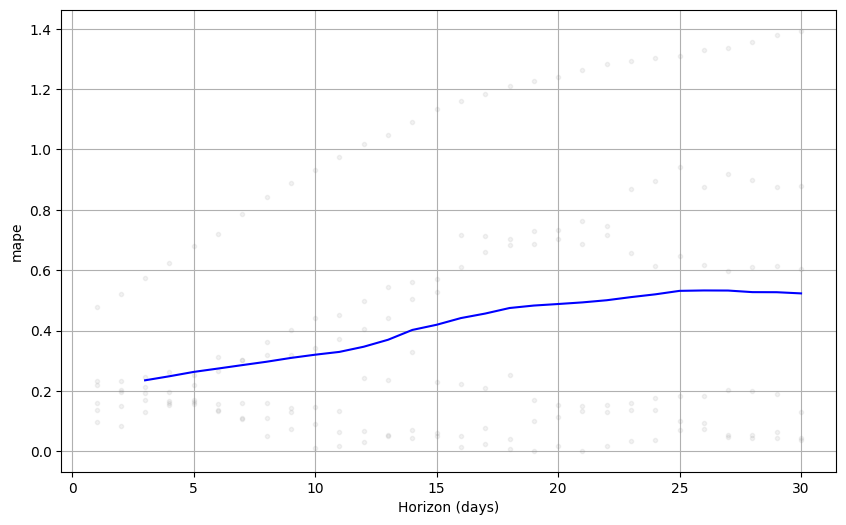

In [30]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Reference

https://www.youtube.com/watch?v=zheSv68vvak&t=9s&pp=ygUWR3JhYiBuIGdvIGluZm8gcHJvcGhldA%3D%3D